In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

seed = 3244
np.random.seed(seed)

h = 50  # height of image
w = 37  # width of image
num_pixels = h * w
num_classes = 7

Using TensorFlow backend.


In [2]:
X = np.load('X_train.npy') # (996, 1850)
y = np.load('y_train.npy') # (996, 1)

X_train, X_test, y_train_categories, y_test_categories = train_test_split(X, y, test_size=0.2, random_state=seed)

In [3]:
def shapeData(data, h=50, w=37):
    return data.reshape(data.shape[0], 1, h, w).astype('float32')

X = shapeData(X)
X_train = shapeData(X_train)
X_test = shapeData(X_test)

In [4]:
def normalize(data):
    return data / 255

X = normalize(X)
X_train = normalize(X_train)
X_test = normalize(X_test)

In [5]:
# one hot encode outputs
y = np_utils.to_categorical(y)
y_train = np_utils.to_categorical(y_train_categories)
y_test = np_utils.to_categorical(y_test_categories)

In [6]:
def baseline_model():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
num_filters = 32  # number of convolutional filters to use
pool_size = (2, 2)  # size of pooling area for max pooling
kernel_size = (5, 5)  # convolution kernel size

def model1():
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model2():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(Convolution2D(32, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    # Note: Keras does automatic shape inference.
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def model3():
    model = Sequential()
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=(1, h, w)))
    model.add(Activation('relu'))
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    return model

def model4():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1), input_shape=(1, h, w)))
    model.add(Convolution2D(64, 3, 3,  activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu")) # 4096
    model.add(Dense(num_classes, activation="softmax"))
    
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
    return model

def model5():
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(1, h, w), border_mode='valid', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='valid', activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
# model = baseline_model()
# model = model1()
# model = model2()
# model = model3()
# model = model4()
model = model5()

nb_epoch = 40
batch_size = 50

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
          verbose=1)

y_pred = model.predict_classes(X_test)
f1_score(y_test_categories, y_pred, average='macro')
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Model accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_16 (Convolution2D) (None, 32, 48, 35)    320         convolution2d_input_7[0][0]      
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 32, 46, 33)    9248        convolution2d_16[0][0]           
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 32, 23, 16)    0           convolution2d_17[0][0]           
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 32, 23, 16)    0           maxpooling2d_11[0][0]            
___________________________________________________________________________________________

0.8867206710374963

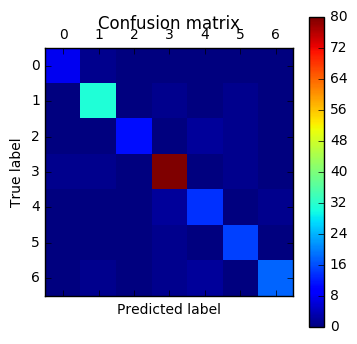

array([[ 8,  1,  0,  0,  0,  0,  0],
       [ 0, 31,  0,  1,  0,  1,  0],
       [ 0,  0, 11,  0,  2,  1,  0],
       [ 1,  1,  0, 80,  0,  1,  0],
       [ 0,  0,  0,  2, 14,  0,  1],
       [ 0,  0,  0,  1,  0, 15,  0],
       [ 0,  1,  0,  1,  2,  0, 18]])

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_categories, y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
cm

In [24]:
model = model3()
model.fit(X, y, 
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
          verbose=1)

Epoch 1/40
966/966 [==============================] - 11s - loss: 1.7499 - acc: 0.3799    
Epoch 2/40
966/966 [==============================] - 12s - loss: 1.6977 - acc: 0.4099    
Epoch 3/40
966/966 [==============================] - 18s - loss: 1.6442 - acc: 0.4193    
Epoch 4/40
966/966 [==============================] - 31s - loss: 1.5497 - acc: 0.4638    
Epoch 5/40
966/966 [==============================] - 27s - loss: 1.4133 - acc: 0.5186    
Epoch 6/40
966/966 [==============================] - 12s - loss: 1.2795 - acc: 0.5559    
Epoch 7/40
966/966 [==============================] - 13s - loss: 1.0686 - acc: 0.6387    
Epoch 8/40
966/966 [==============================] - 22s - loss: 0.9827 - acc: 0.6553    
Epoch 9/40
966/966 [==============================] - 31s - loss: 0.9210 - acc: 0.6553    
Epoch 10/40
966/966 [==============================] - 14s - loss: 0.7460 - acc: 0.7402    
Epoch 11/40
966/966 [==============================] - 21s - loss: 0.6940 - acc: 0.7640  

In [27]:
X_test_given = normalize(shapeData(np.load('X_test.npy')))

classes = model.predict_classes(X_test_given, batch_size=32)
proba = model.predict_proba(X_test_given, batch_size=32)

print(classes)

322/322 [==============================] - 1s     
[1 4 6 1 3 2 0 3 0 6 1 3 3 3 3 0 3 1 3 1 3 0 3 0 3 0 4 1 4 3 2 6 3 1 1 6 3
 6 3 6 3 6 3 1 3 5 4 2 3 3 3 3 3 3 4 2 1 5 4 0 6 4 2 3 4 3 1 3 3 3 3 3 3 2
 3 1 2 3 3 3 3 3 6 3 6 4 1 1 2 1 0 4 2 3 6 3 3 6 1 3 3 6 3 3 3 4 3 6 2 4 3
 3 0 3 3 3 6 5 6 3 2 0 6 3 6 3 4 1 2 4 2 3 3 1 3 3 1 2 3 3 1 6 1 3 3 1 3 2
 3 3 3 4 3 1 6 3 5 1 3 3 1 5 3 0 5 4 6 2 3 0 3 2 2 3 1 1 3 3 3 3 5 3 1 4 0
 6 4 1 3 3 1 5 6 3 3 3 2 3 1 4 3 3 3 3 3 2 3 6 1 4 1 0 6 6 2 1 3 2 3 3 1 6
 2 3 6 6 3 6 3 3 3 3 3 3 3 3 2 6 3 6 3 6 2 3 3 3 3 1 6 5 3 1 0 1 3 1 1 0 1
 2 3 3 3 3 3 3 4 1 3 3 5 3 4 3 3 3 6 1 1 1 3 3 3 6 4 3 0 2 3 3 3 3 6 3 6 3
 2 3 1 6 4 6 2 3 1 3 4 2 3 1 3 2 3 0 3 0 3 2 3 3 3 1]


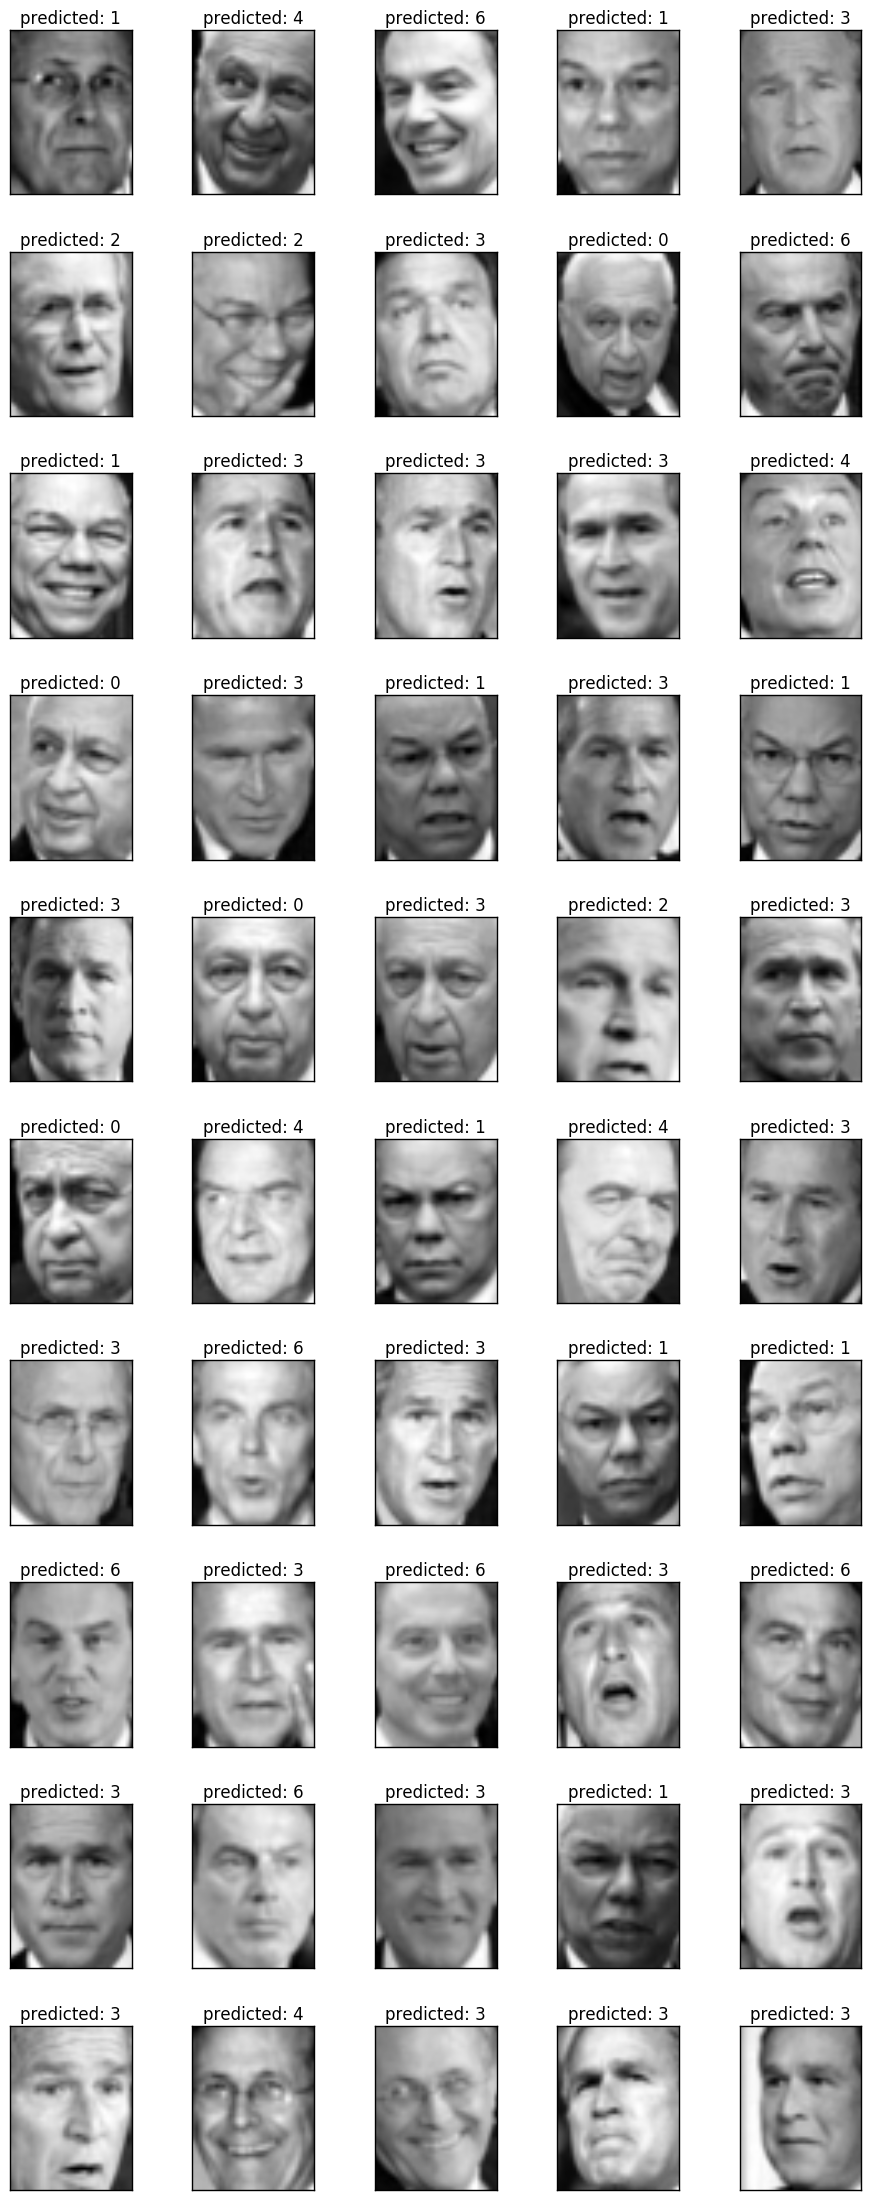

In [13]:
def plot_gallery(images, titles, h, w, n_row=10, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, i):
    return 'predicted: %s' % y_pred[i]

prediction_titles = [title(classes, i) for i in range(classes.shape[0])]

plot_gallery(np.load('X_test.npy'), prediction_titles, h, w)

plt.show()

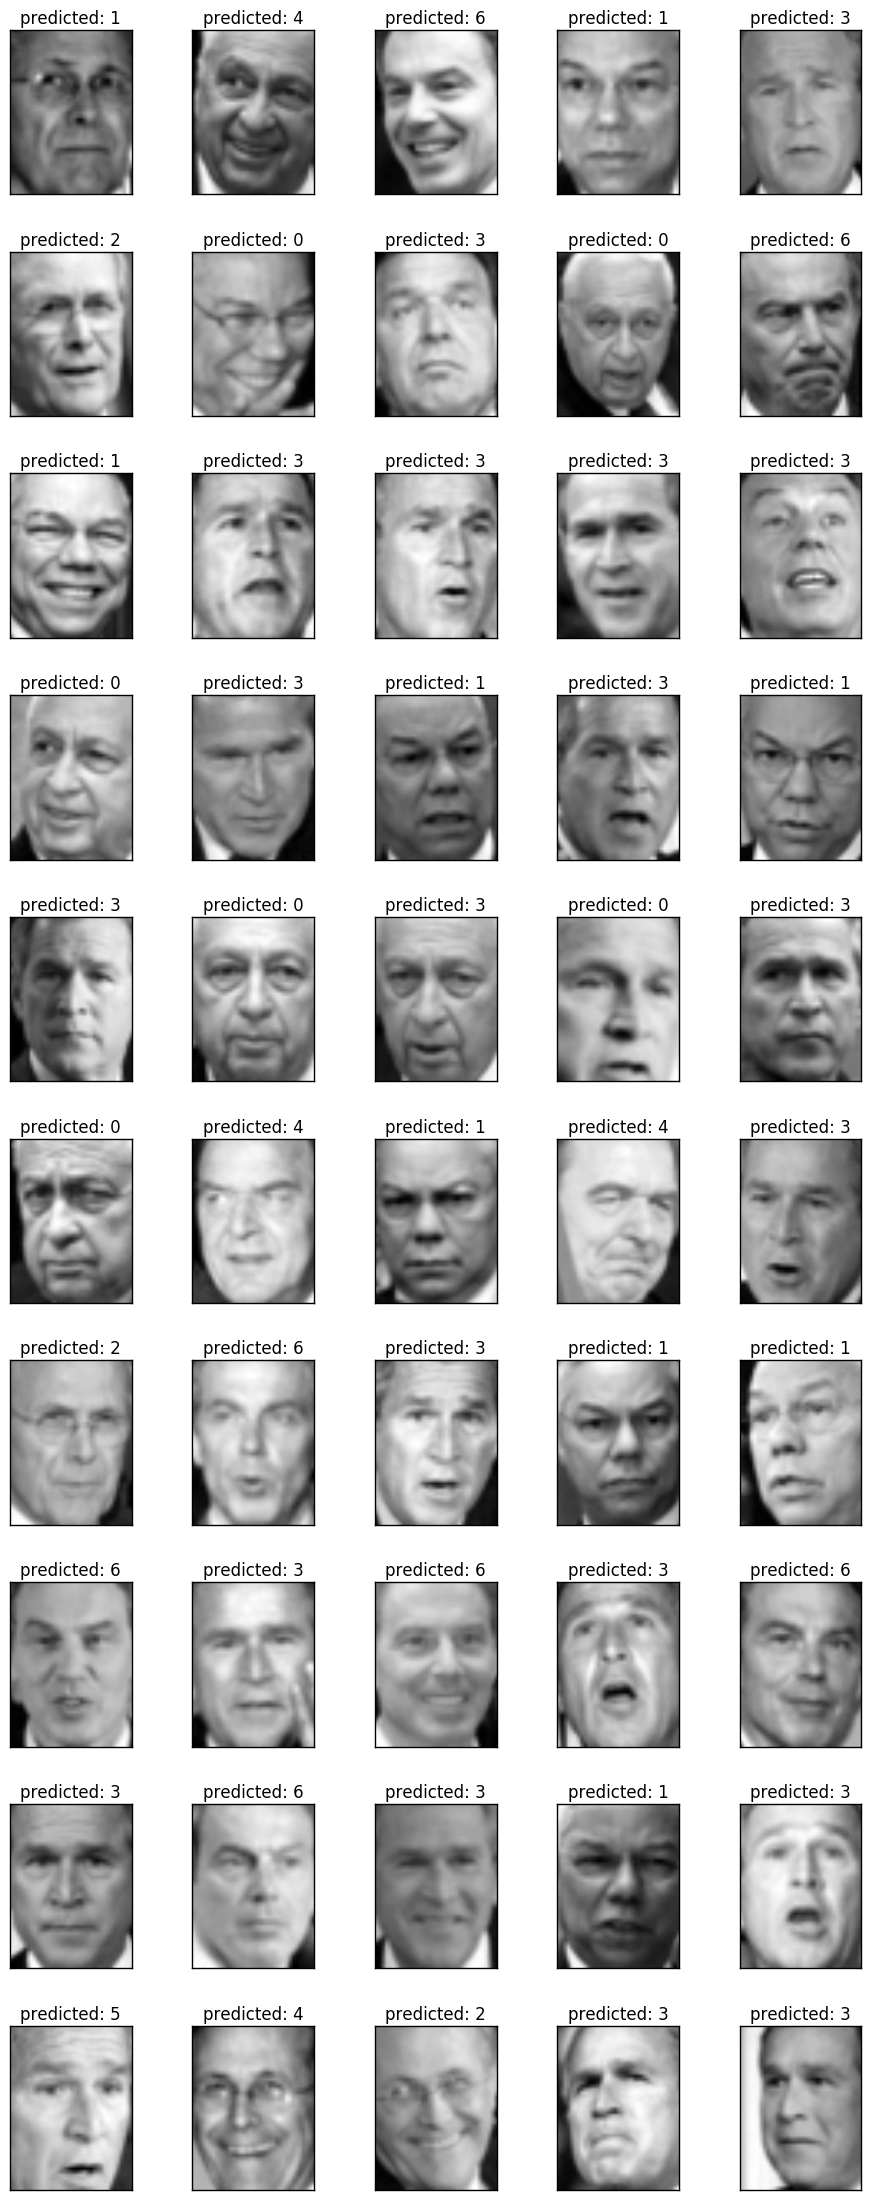

In [26]:
prediction_titles = [title(classes, i) for i in range(classes.shape[0])]

plot_gallery(np.load('X_test.npy'), prediction_titles, h, w)

plt.show()